# 2D Best-Of Call European Option Pricing with DGM

## 1. Introduction

A brief description of the notebook’s purpose:
- Solve the multi-dimensional PDE for a 2-asset best-of call  
- Compare the PINN/DGM solution to a Monte-Carlo reference  
- Produce 2D/3D visualizations and error metrics
- Compute and visualize Greeks (Δ, Γ, θ) across runs

## 2. Environment and Imports

In [1]:
!pip install -q tqdm
import tensorflow as tf, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.notebook import trange
import time, math
import os

In [10]:
!pip install -U ipywidgets nbformat nbconvert
import ipywidgets as widgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/MyDrive/PINNs/Call BO'

## 3. Hyperparameters and Constants

In [ ]:
# Market and PDE parameters
r, T, K = 0.05, 1.0, 100.0
d = 2
sigma = [0.25] * d
rho = 0.0
S_low, S_high = 1e-8, 3 * K
S_upper, t_low = 1.3 * S_high, 1e-8

# Neural network and training parameters
n_layers, n_nodes = 3, 80
learning_rate = 1e-4
n_samples_pde = n_samples_terminal = 3000
n_epochs = 10000

## 4. Payoff Function and Sampler

In [ ]:
def payoff(S, kind="call", operator="max"):
    A = tf.reduce_max(S, 1, True) if operator == "max" else tf.reduce_min(S, 1, True)
    return tf.nn.relu(A - K) if kind == "call" else tf.nn.relu(K - A)

In [ ]:
def sampler(n_pde, n_term, d):
    t_p = np.random.uniform(t_low, T, (n_pde, 1))
    S_p = np.random.uniform(S_low, S_upper, (n_pde, d))
    t_T = np.full((n_term, 1), T)
    S_T = np.random.uniform(S_low, S_upper, (n_term, d))
    return tuple(tf.constant(x, tf.float32) for x in (t_p, S_p, t_T, S_T))

## 5. DGM Network Architecture

### 5.1 Custom LSTM-style Layer

In [ ]:
class LSTMLayer(tf.keras.layers.Layer):
    def __init__(self, inp, out, t1=tf.nn.tanh, t2=tf.nn.tanh):
        super().__init__()
        self.t1, self.t2 = t1, t2

        self.Uz = self.add_weight(shape=[inp, out], initializer="glorot_uniform")
        self.Ug = self.add_weight(shape=[inp, out], initializer="glorot_uniform")
        self.Ur = self.add_weight(shape=[inp, out], initializer="glorot_uniform")
        self.Uh = self.add_weight(shape=[inp, out], initializer="glorot_uniform")

        self.Wz = self.add_weight(shape=[out, out], initializer="glorot_uniform")
        self.Wg = self.add_weight(shape=[out, out], initializer="glorot_uniform")
        self.Wr = self.add_weight(shape=[out, out], initializer="glorot_uniform")
        self.Wh = self.add_weight(shape=[out, out], initializer="glorot_uniform")

        self.bz = self.add_weight(shape=[1, out], initializer="zeros")
        self.bg = self.add_weight(shape=[1, out], initializer="zeros")
        self.br = self.add_weight(shape=[1, out], initializer="zeros")
        self.bh = self.add_weight(shape=[1, out], initializer="zeros")

    def call(self, S, X):
        Z = self.t1(X @ self.Uz + S @ self.Wz + self.bz)
        G = self.t1(X @ self.Ug + S @ self.Wg + self.bg)
        R = self.t1(X @ self.Ur + S @ self.Wr + self.br)
        H = self.t2(X @ self.Uh + (R * S) @ self.Wh + self.bh)
        return (1 - G) * H + Z * S

### 5.2 DGMNet Model

In [ ]:
class DGMNet(tf.keras.Model):
    def __init__(self, inp_dim, hid_dim, n_layers):
        super().__init__()
        self.inp = tf.keras.layers.Dense(hid_dim, activation='tanh')
        self.hid = [LSTMLayer(inp_dim, hid_dim) for _ in range(n_layers)]
        self.out = tf.keras.layers.Dense(1)
    def call(self, t, *S):
        X = tf.concat([t] + list(S), 1)
        S_lat = self.inp(X)
        for lstm in self.hid:
            S_lat = lstm(S_lat, X)
        return self.out(S_lat)

In [ ]:
model0 = DGMNet(d + 1, n_nodes, n_layers)
_ = model0(tf.zeros((1, d + 1), dtype=tf.float32))
model0.summary()

Model: "dgm_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (1, 80)                │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTMLayer)          │ ?                      │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTMLayer)        │ ?                      │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTMLayer)        │ ?                      │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,041 (316.57 KB)

 Trainable params: 81,041 (316.57 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Loss Computation and Training Step

In [ ]:
@tf.function
def compute_loss(model, t_p, S_p, t_T, S_T, α=1.0):
    S_split = tf.split(S_p, d, 1)
    with tf.GradientTape(persistent=True) as g2:
        g2.watch([t_p] + S_split)
        with tf.GradientTape(persistent=True) as g1:
            g1.watch([t_p] + S_split)
            V = model(t_p, *S_split)
        V_t = g1.gradient(V, t_p)
        V_s = [g1.gradient(V, s) for s in S_split]
    V_ss = [g2.gradient(V_s[i], S_split[i]) for i in range(d)]
    pde = V_t
    for i in range(d):
        Si = S_split[i]
        pde += r * Si * V_s[i] + 0.5 * sigma[i]**2 * Si**2 * V_ss[i]
    pde -= r * V
    loss_pde = tf.reduce_mean(pde**2)
    V_T = model(t_T, *tf.split(S_T, d, 1))
    loss_T = tf.reduce_mean((V_T - payoff(S_T))**2)
    return loss_pde + α * loss_T, loss_pde, loss_T

In [ ]:
def train_run(run_id: int):
    # fix seeds
    tf.random.set_seed(42 + run_id)
    np.random.seed(42 + run_id)

    # model + build
    model = DGMNet(d + 1, n_nodes, n_layers)
    _ = model(tf.zeros((1, d + 1)))
    opt = tf.keras.optimizers.Adam(learning_rate)
    opt.build(model.trainable_variables)

    # one-step returns losses
    @tf.function
    def step(t_p, S_p, t_T, S_T):
        with tf.GradientTape() as tape:
            Ltot, Lpde, Lterm = compute_loss(model, t_p, S_p, t_T, S_T)
        grads = tape.gradient(Ltot, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        return Ltot, Lpde, Lterm

    # training loop
    t0  = time.time()
    bar = trange(n_epochs, desc=f"Run {run_id}", unit="epoch")
    for e in bar:
        # LR schedule
        if e == 8000:
            opt.learning_rate.assign(learning_rate * 0.1)
            bar.write(f"Run {run_id}: LR ×0.1 at epoch {e}")

        # sample + one step
        batch = sampler(n_samples_pde, n_samples_terminal, d)
        Ltot, Lpde, Lterm = step(*batch)

        # update losses
        if e % 100 == 0:
            bar.set_postfix(loss=float(Ltot),
                            pde =float(Lpde),
                            term=float(Lterm))

    bar.close()
    runtime = time.time() - t0

    # save weights
    fname = f"{drive_path}/model_Call_BO_run_{run_id}.weights.h5"
    model.save_weights(fname)
    print(f"Run {run_id} finished in {runtime:.1f}s — weights ⇒ {fname}")

    return model, runtime

## 7. Training Loop: Load Models or Retrain


In [ ]:
N_runs = 5

### 7.1 Load Pretrained Weights

In [ ]:
models = []
for run_id in range(N_runs):
    m = DGMNet(d + 1, n_nodes, n_layers)
    _ = m(tf.zeros((1, d + 1), dtype=tf.float32))
    m.load_weights(f"{drive_path}/model_Call_BO_run_{run_id}.weights.h5")
    models.append(m)
    print(f"✔ Loaded {drive_path}/model_Call_BO_run_{run_id}.weights.h5")
print(f"\nLoaded weights for {len(models)} runs")

✔ Loaded /content/drive/MyDrive/PINNs/Weights Call BO/model_Call_BO_run_0.weights.h5
✔ Loaded /content/drive/MyDrive/PINNs/Weights Call BO/model_Call_BO_run_1.weights.h5
✔ Loaded /content/drive/MyDrive/PINNs/Weights Call BO/model_Call_BO_run_2.weights.h5
✔ Loaded /content/drive/MyDrive/PINNs/Weights Call BO/model_Call_BO_run_3.weights.h5
✔ Loaded /content/drive/MyDrive/PINNs/Weights Call BO/model_Call_BO_run_4.weights.h5

Loaded weights for 5 runs


### 7.2 Retrain Independent Runs

In [ ]:
models   = []
runtimes = []

for k in range(N_runs):
    model_k, sec = train_run(k)
    models.append(model_k)
    runtimes.append(sec)

print("all runs finished")

Run 0:   0%|          | 0/15000 [00:00<?, ?epoch/s]

Run 0: LR ×0.1 at epoch 12000
Run 0 finished in 691.1s — weights ⇒ /content/drive/MyDrive/PINNs/Weights Call BO/model_Call_BO_run_0.weights.h5


Run 1:   0%|          | 0/15000 [00:00<?, ?epoch/s]

Run 1: LR ×0.1 at epoch 12000
Run 1 finished in 692.2s — weights ⇒ /content/drive/MyDrive/PINNs/Weights Call BO/model_Call_BO_run_1.weights.h5


Run 2:   0%|          | 0/15000 [00:00<?, ?epoch/s]

Run 2: LR ×0.1 at epoch 12000
Run 2 finished in 690.7s — weights ⇒ /content/drive/MyDrive/PINNs/Weights Call BO/model_Call_BO_run_2.weights.h5


Run 3:   0%|          | 0/15000 [00:00<?, ?epoch/s]

Run 3: LR ×0.1 at epoch 12000
Run 3 finished in 692.0s — weights ⇒ /content/drive/MyDrive/PINNs/Weights Call BO/model_Call_BO_run_3.weights.h5


Run 4:   0%|          | 0/15000 [00:00<?, ?epoch/s]

Run 4: LR ×0.1 at epoch 12000
Run 4 finished in 693.5s — weights ⇒ /content/drive/MyDrive/PINNs/Weights Call BO/model_Call_BO_run_4.weights.h5
all runs finished


## 8. Visualizing the DGM Solution

### 8.1 Utility Functions and Quick Checks

In [ ]:
t_pt  = tf.constant([[0.5]], tf.float32)
S1_pt = tf.constant([[100.]], tf.float32)
S2_pt = tf.constant([[100.]], tf.float32)

for i, mdl in enumerate(models):
    price = mdl(t_pt, S1_pt, S2_pt).numpy()[0, 0]
    print(f"Price run {i}: {price:.6f}")

Price run 0: 17.066668
Price run 1: 12.832187
Price run 2: 13.296319
Price run 3: 13.088646
Price run 4: 11.360408


In [ ]:
def model_surface(model, t_val, g=50):

    S1 = np.linspace(S_low, S_high, g, dtype=np.float32)
    S2 = np.linspace(S_low, S_high, g, dtype=np.float32)
    G1, G2 = np.meshgrid(S1, S2)
    t_batch = np.full_like(G1, t_val, dtype=np.float32)

    with tf.device("/CPU:0"):
        flat_preds = model(
            tf.constant(t_batch.reshape(-1, 1)),
            tf.constant(G1.reshape(-1, 1)),
            tf.constant(G2.reshape(-1, 1))
        ).numpy()

    return flat_preds.reshape(g, g)

In [ ]:
# Parameters
t_slices = [0.0, 1/3, 2/3, 1.0]  # the four time-slices
g        = 300                    # grid resolution

# Build the S1–S2 mesh
S1 = np.linspace(S_low, S_high, g, dtype=np.float32)
S2 = np.linspace(S_low, S_high, g, dtype=np.float32)
G1, G2 = np.meshgrid(S1, S2)

# Build the S1–t for S2 fixed at strike mesh
S2_fixed  = K
t_vals   = np.linspace(t_low, T, g)
T_grid, S1_grid = np.meshgrid(t_vals, S1)
S2_grid = np.full_like(T_grid, S2_fixed)
S2_vals = np.full_like(S1, S2_fixed)

# colormap
cmap   = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(len(models))]

### 8.2 3D Surface at Selected Times

#### 8.2.1 3D Overlay of Individual Runs

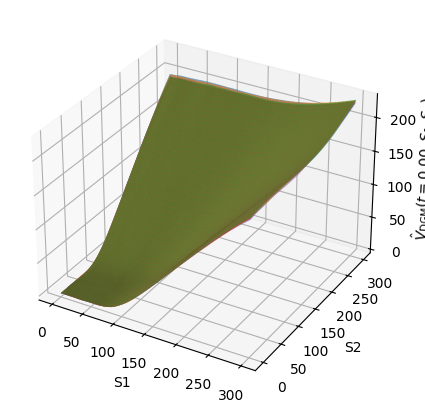

Saved plot for t=0.00 → overlay_runs_Call_BO_t00.png


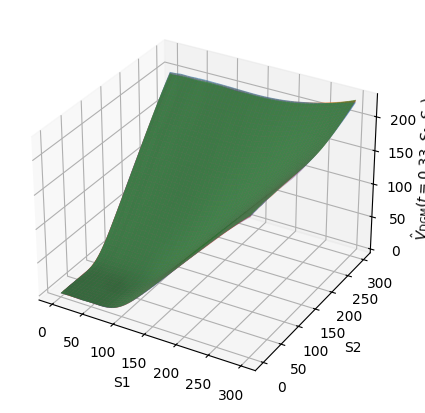

Saved plot for t=0.33 → overlay_runs_Call_BO_t33.png


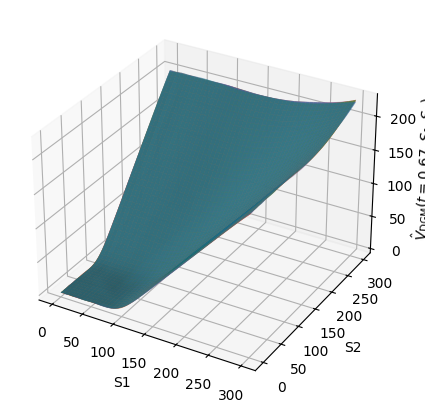

Saved plot for t=0.67 → overlay_runs_Call_BO_t66.png


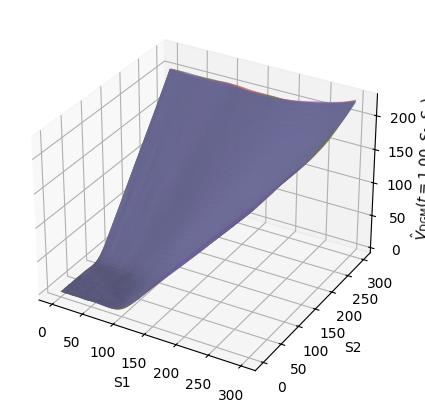

Saved plot for t=1.00 → overlay_runs_Call_BO_t100.png


In [ ]:
# Loop over time slices
for t_val in t_slices:
    surfaces = [model_surface(m, t_val, g) for m in models]
    fig = plt.figure(figsize=(6, 5))
    ax  = fig.add_subplot(111, projection='3d')

    legend_handles = []
    for i, surf in enumerate(surfaces):
        ax.plot_surface(
            G1, G2, surf,
            color=colors[i],
            alpha=0.6,
            edgecolor='none'
        )

    ax.set_xlabel('S1')
    ax.set_ylabel('S2')
    ax.set_zlabel(
        f'$\\hat{{V}}_{{\\mathrm{{DGM}}}}(t={t_val:.2f}, S_1, S_2)$',
        labelpad=1
    )

    filename = f"overlay_runs_Call_BO_t{int(t_val*100):02d}.png"
    fullpath = f"{drive_path}/{filename}"
    plt.savefig(fullpath, dpi=300)
    plt.show()

    print(f"Saved plot for t={t_val:.2f} → {filename}")

#### 8.2.2 3D Mean Surface ± 1 Std Dev

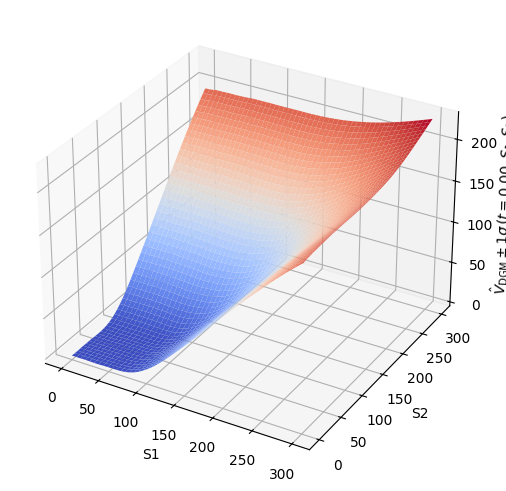

Saved plot for t=0.00 → mean_coolwarm_Call_BO_t00.png


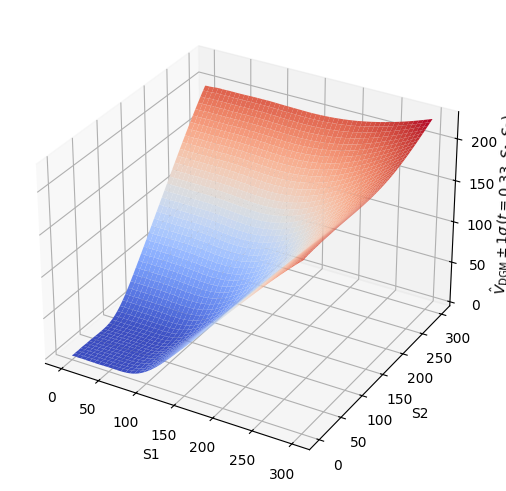

Saved plot for t=0.33 → mean_coolwarm_Call_BO_t33.png


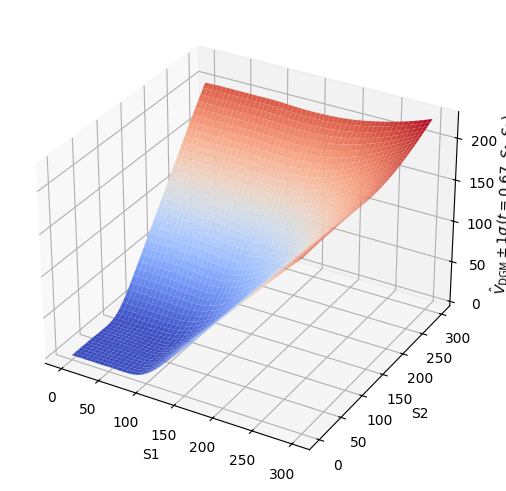

Saved plot for t=0.67 → mean_coolwarm_Call_BO_t66.png


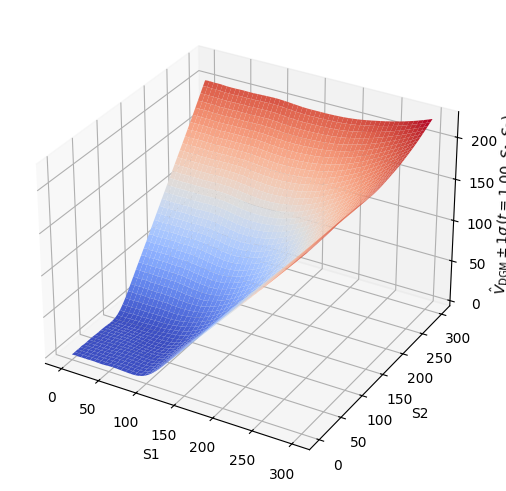

Saved plot for t=1.00 → mean_coolwarm_Call_BO_t100.png


In [ ]:
# Loop over time slices
for t_val in t_slices:
    run_surfs = [model_surface(m, t_val, g) for m in models]
    stacked   = np.stack(run_surfs, axis=0)

    # Compute pointwise mean and std
    mean_surf = stacked.mean(axis=0)
    std_surf  = stacked.std(axis=0)

    # Plot mean + ±1σ bands
    fig = plt.figure(figsize=(6, 5))
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot_surface(G1, G2, mean_surf,
                    cmap='coolwarm', edgecolor='none')
    band_color = 'gray'
    ax.plot_surface(G1, G2, mean_surf + std_surf,
                    color=band_color, alpha=0.2, edgecolor='none')
    ax.plot_surface(G1, G2, mean_surf - std_surf,
                    color=band_color, alpha=0.2, edgecolor='none')

    ax.set_xlabel('S1')
    ax.set_ylabel('S2')
    ax.set_zlabel(
        f'$\\hat{{V}}_{{\\mathrm{{DGM}}}}\\pm1\\sigma\\,(t={t_val:.2f}, S_1, S_2)$',
        labelpad=1
    )

    filename = f"mean_coolwarm_Call_BO_t{int(t_val*100):02d}.png"
    fullpath = f"{drive_path}/{filename}"
    plt.tight_layout()
    plt.savefig(fullpath, dpi=300)
    plt.show()
    print(f"Saved plot for t={t_val:.2f} → {filename}")

### 8.3 2D Mean Heatmap

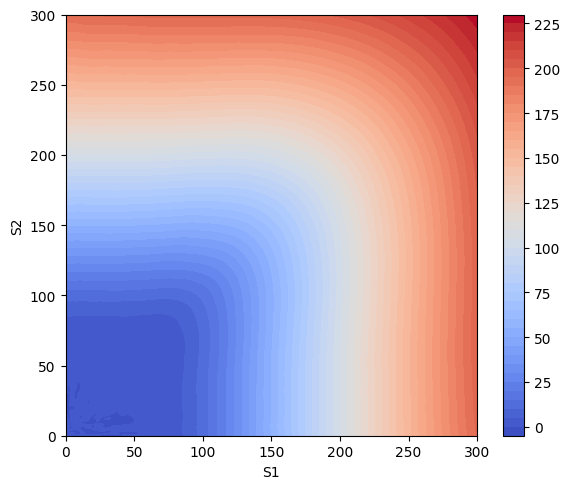

Saved plot for t=0.00 → heatmap_mean_runs_Call_BO_t00.png


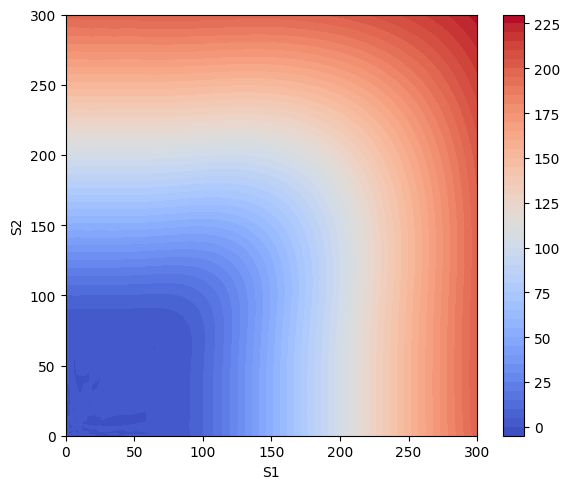

Saved plot for t=0.33 → heatmap_mean_runs_Call_BO_t33.png


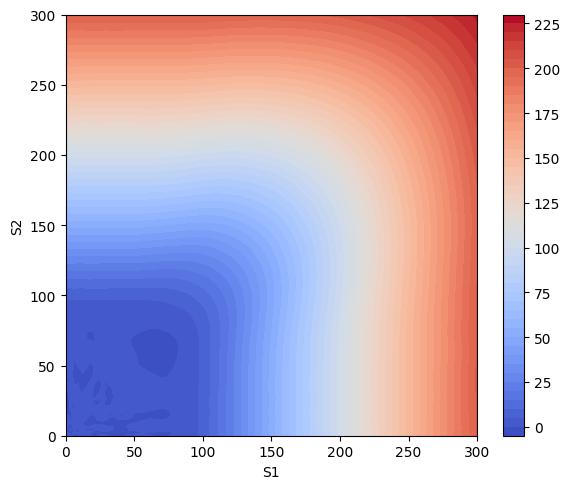

Saved plot for t=0.67 → heatmap_mean_runs_Call_BO_t66.png


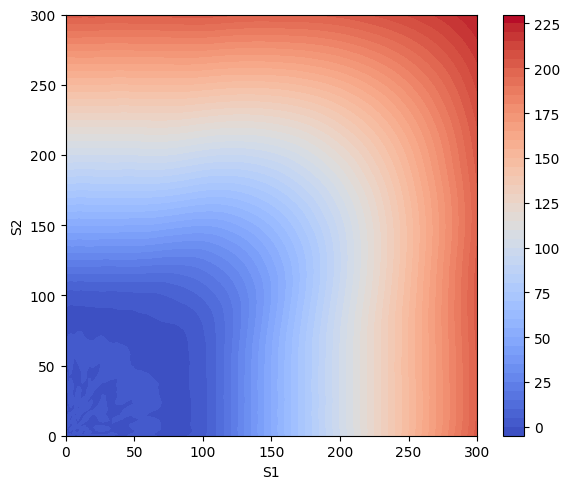

Saved plot for t=1.00 → heatmap_mean_runs_Call_BO_t100.png


In [ ]:
# Loop over time slices
for t_val in t_slices:
    run_surfs = [ model_surface(m, t_val, g) for m in models ]
    mean_surf = np.mean(np.stack(run_surfs, axis=0), axis=0)

    fig, ax = plt.subplots(figsize=(6, 5))
    cf = ax.contourf(
        G1, G2, mean_surf,
        levels=50,
        cmap='coolwarm'
    )
    ax.set_xlabel('S1')
    ax.set_ylabel('S2')
    cbar = fig.colorbar(cf, ax=ax)

    filename = f"heatmap_mean_runs_Call_BO_t{int(t_val*100):02d}.png"
    fullpath = f"{drive_path}/{filename}"
    plt.tight_layout()
    plt.savefig(fullpath, dpi=300)
    plt.show()
    print(f"Saved plot for t={t_val:.2f} → {filename}")

### 8.4 2D Slices at Fixed S2

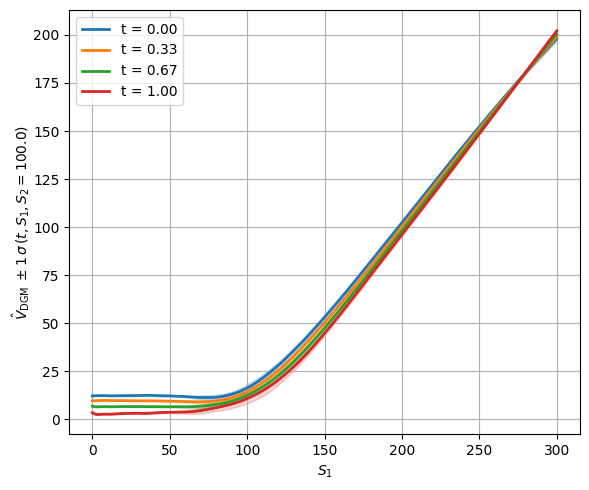

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']                # New colour palette
colors     = [prop_cycle[i % len(prop_cycle)] for i in range(len(t_slices))]

plt.figure(figsize=(6, 5))

for idx, t in enumerate(t_slices):
    preds = []
    for m in models:
        t_in  = tf.constant(np.full((g,1), t), dtype=tf.float32)
        S1_in = tf.constant(S1.reshape(-1,1),    dtype=tf.float32)
        S2_in = tf.constant(S2_vals.reshape(-1,1),    dtype=tf.float32)
        with tf.device('/CPU:0'):
            p = m(t_in, S1_in, S2_in).numpy().flatten()
        preds.append(p)
    data      = np.stack(preds, axis=0)
    mean_line = data.mean(axis=0)
    std_line  = data.std(axis=0)

    c = colors[idx]
    plt.plot(S1, mean_line, color=c, linewidth=2, label=f"t = {t:.2f}")
    plt.fill_between(
        S1,
        mean_line - std_line,
        mean_line + std_line,
        color=c,
        alpha=0.2
    )

plt.xlabel(r"$S_1$")
plt.ylabel(rf"$\hat{{V}}_{{\mathrm{{DGM}}}}\;\pm 1\,\sigma\,(t,S_1,S_2={S2_fixed:.1f})$",labelpad=1)
plt.legend()
plt.grid(True)
filename = "timeslices_mean_envelope_Call_BO.png"
fullpath = f"{drive_path}/{filename}"
plt.tight_layout()
plt.savefig(fullpath, dpi=300)
plt.show()

### 8.5 Surface Over Time vs S1 (S2 fixed)

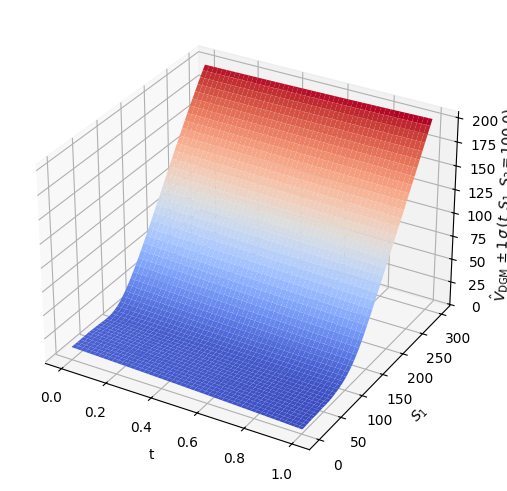

In [ ]:
all_preds = []
for m in models:
    t_in  = tf.convert_to_tensor(T_grid.reshape(-1,1), tf.float32)
    S1_in = tf.convert_to_tensor(S1_grid.reshape(-1,1), tf.float32)
    S2_in = tf.convert_to_tensor(S2_grid.reshape(-1,1), tf.float32)
    with tf.device('/CPU:0'):
        V_pred = m(t_in, S1_in, S2_in).numpy().reshape(g, g)
    all_preds.append(V_pred)

stacked    = np.stack(all_preds, axis=0)
mean_surf  = stacked.mean(axis=0)
std_surf   = stacked.std(axis=0)

fig = plt.figure(figsize=(6, 5))
ax  = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    T_grid, S1_grid, mean_surf,
    cmap='coolwarm', edgecolor='none'
)

band_color = 'gray'
ax.plot_surface(
    T_grid, S1_grid, mean_surf + std_surf,
    color=band_color, alpha=0.2, edgecolor='none'
)
ax.plot_surface(
    T_grid, S1_grid, mean_surf - std_surf,
    color=band_color, alpha=0.2, edgecolor='none'
)

ax.set_xlabel('t')
ax.set_ylabel(r'$S_1$')
ax.set_zlabel(
    rf'$\hat{{V}}_{{\mathrm{{DGM}}}}\,\pm 1\,\sigma\,(t,S_1,S_2={S2_fixed})$',
    labelpad=1
)
filename = 'surface_time_vs_S1_std_Call_BO.png'
fullpath = f"{drive_path}/{filename}"
plt.tight_layout()
plt.savefig(fullpath, dpi=300)
plt.show()

## 9. Monte-Carlo Comparison and Error Analysis

### 9.1 Vectorized Monte-Carlo Reference

In [ ]:
@tf.function
def mc_max_call_tf(S1, S2, dt,
                   K, r, sigma1, sigma2, rho, n_paths):

    batch = tf.shape(S1)[0]
    Z1 = tf.random.normal((batch, n_paths))
    Z2 = rho * Z1 + tf.sqrt(1. - rho**2) * tf.random.normal((batch, n_paths))

    S1_T = tf.expand_dims(S1, -1) * tf.exp((r - 0.5 * sigma1**2) * dt
                                           + sigma1 * tf.sqrt(dt) * Z1)
    S2_T = tf.expand_dims(S2, -1) * tf.exp((r - 0.5 * sigma2**2) * dt
                                           + sigma2 * tf.sqrt(dt) * Z2)

    payoff = tf.nn.relu(tf.maximum(S1_T, S2_T) - K)
    return tf.exp(-r * dt) * tf.reduce_mean(payoff, axis=1)

### 9.2 Error Computation Across Independent Runs

In [ ]:
n_paths_MC = 100_000
batch_size = 250
S1_flat, S2_flat = G1.ravel(), G2.ravel()

In [ ]:
# Monte-Carlo baseline + per-run DGM error surfaces
mc_baseline = {}
abs_error_runs = {t: [] for t in t_slices}

for t in t_slices:
    dt = np.float32(T - t)

    # Monte-Carlo baseline
    V_mc = np.empty_like(S1_flat, dtype=np.float32)
    for j in trange(0, len(S1_flat), batch_size,
                    desc=f"MC baseline t={t:.2f}", leave=False):
        sl = slice(j, j+batch_size)
        with tf.device("/GPU:0"):
            V_mc[sl] = mc_max_call_tf(
                tf.constant(S1_flat[sl], dtype=tf.float32),
                tf.constant(S2_flat[sl], dtype=tf.float32),
                dt, K, r, sigma[0], sigma[1], rho, n_paths_MC
            ).numpy()

    mc_baseline[t] = V_mc.reshape(g, g)

    # For each independent model, we compute |MC − DGM|
    for m in models:
        t_tensor  = tf.constant(np.full((len(S1_flat),1), t), dtype=tf.float32)
        S1_tensor = tf.constant(S1_flat.reshape(-1,1),      dtype=tf.float32)
        S2_tensor = tf.constant(S2_flat.reshape(-1,1),      dtype=tf.float32)
        with tf.device("/CPU:0"):
            V_dgm = m(t_tensor, S1_tensor, S2_tensor).numpy().flatten()

        err = np.abs(V_mc - V_dgm).reshape(g, g)
        abs_error_runs[t].append(err)

print("MC baseline and per-run error surfaces stored.")

MC baseline t=0.00:   0%|          | 0/360 [00:00<?, ?it/s]

MC baseline t=0.33:   0%|          | 0/360 [00:00<?, ?it/s]

MC baseline t=0.67:   0%|          | 0/360 [00:00<?, ?it/s]

MC baseline t=1.00:   0%|          | 0/360 [00:00<?, ?it/s]

MC baseline and per-run error surfaces stored.


In [ ]:
S1_labels = [f"{s:.2f}" for s in S1]
S2_labels = [f"{s:.2f}" for s in S2]

# Monte-Carlo baseline DataFrame at t = 0.0
df_MC0 = pd.DataFrame(
    mc_baseline[0.0],
    index=S2_labels,
    columns=S1_labels
).round(2)

print("Monte-Carlo baseline at t = 0.0")
display(df_MC0)

# PINN mean prediction across runs at t = 0.0
t0 = np.float32(0.0)
t_tensor  = tf.constant(np.full((g*g,1), t0), dtype=tf.float32)
S1_tensor = tf.constant(np.array(S1_labels, dtype=np.float32).reshape(-1,1).repeat(g, axis=1).ravel().reshape(-1,1), dtype=tf.float32)
S2_tensor = tf.constant(np.array(S2_labels, dtype=np.float32).reshape(1,-1).repeat(g, axis=0).ravel().reshape(-1,1), dtype=tf.float32)

preds = []
for m in models:
    with tf.device("/CPU:0"):
        flat = m(t_tensor, S1_tensor, S2_tensor).numpy().flatten()
    preds.append(flat)

mean_flat = np.stack(preds, axis=0).mean(axis=0)
mean_grid = mean_flat.reshape(g, g)

df_PINN0 = pd.DataFrame(
    mean_grid,
    index=S2_labels,
    columns=S1_labels
).round(2)

print("Mean PINN prediction at t = 0.0")
display(df_PINN0)

Monte-Carlo baseline at t = 0.0


,0.00,1.00,2.01,3.01,4.01,5.02,6.02,7.02,8.03,9.03,...,290.97,291.97,292.98,293.98,294.98,295.99,296.99,297.99,299.00,300.00
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,195.660004,197.190002,197.660004,199.179993,199.649994,200.570007,202.020004,203.149994,204.000000,204.949997
1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,195.610001,196.869995,197.539993,198.949997,199.770004,200.740005,202.169998,202.740005,204.350006,204.759995
2.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,196.119995,197.229996,197.750000,198.570007,199.800003,201.000000,201.690002,202.320007,204.009995,204.960007
3.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,195.929993,196.960007,198.009995,199.210007,199.990005,200.910004,201.630005,203.050003,203.679993,205.160004
4.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,195.820007,196.679993,197.970001,198.929993,199.449997,200.899994,201.850006,202.759995,203.610001,205.179993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295.99,200.869995,200.940002,200.929993,201.009995,201.449997,200.990005,200.669998,200.850006,200.820007,200.470001,...,239.759995,240.009995,240.490005,241.080002,242.100006,242.529999,242.800003,243.270004,244.130005,244.300003
296.99,201.179993,201.990005,201.839996,201.750000,201.990005,201.910004,201.990005,202.350006,202.270004,201.960007,...,240.250000,240.520004,241.320007,241.460007,242.550003,242.919998,243.880005,243.899994,244.380005,245.250000
297.99,202.970001,203.009995,202.699997,202.339996,202.649994,203.110001,202.770004,202.979996,203.130005,202.779999,...,240.630005,241.279999,242.039993,242.369995,243.210007,243.839996,244.070007,244.710007,244.809998,245.639999
299.00,204.399994,203.979996,204.039993,203.470001,203.690002,204.070007,203.419998,204.190002,203.539993,203.800003,...,241.449997,241.970001,242.740005,242.880005,243.279999,244.130005,244.750000,245.160004,245.869995,246.110001


Mean PINN prediction at t = 0.0


,0.00,1.00,2.01,3.01,4.01,5.02,6.02,7.02,8.03,9.03,...,290.97,291.97,292.98,293.98,294.98,295.99,296.99,297.99,299.00,300.00
0.00,-0.310000,0.040000,0.180000,0.030000,-0.070000,-0.030000,-0.040000,0.010000,0.060000,0.070000,...,187.139999,187.919998,188.699997,189.470001,190.240005,191.009995,191.779999,192.539993,193.300003,194.050003
1.00,0.070000,0.080000,0.100000,0.020000,-0.000000,-0.000000,0.030000,0.050000,0.030000,0.000000,...,187.289993,188.070007,188.860001,189.630005,190.410004,191.179993,191.949997,192.710007,193.479996,194.229996
2.01,0.090000,0.090000,0.030000,0.010000,0.000000,0.050000,0.030000,0.030000,0.030000,0.040000,...,187.380005,188.169998,188.960007,189.740005,190.520004,191.300003,192.059998,192.830002,193.600006,194.360001
3.01,0.060000,-0.000000,0.020000,-0.000000,-0.000000,-0.030000,-0.010000,-0.010000,-0.010000,-0.010000,...,187.410004,188.199997,189.000000,189.779999,190.559998,191.339996,192.110001,192.880005,193.649994,194.419998
4.01,0.220000,0.020000,-0.030000,-0.040000,0.010000,-0.020000,-0.030000,-0.020000,-0.020000,0.000000,...,187.410004,188.199997,188.990005,189.779999,190.559998,191.350006,192.119995,192.889999,193.669998,194.429993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295.99,191.990005,192.259995,192.449997,192.580002,192.679993,192.770004,192.860001,192.949997,193.050003,193.130005,...,223.679993,224.009995,224.339996,224.669998,225.000000,225.330002,225.649994,225.979996,226.309998,226.630005
296.99,192.770004,193.050003,193.240005,193.369995,193.470001,193.559998,193.660004,193.750000,193.850006,193.929993,...,224.059998,224.380005,224.710007,225.029999,225.360001,225.679993,226.000000,226.320007,226.649994,226.960007
297.99,193.550003,193.830002,194.020004,194.160004,194.259995,194.360001,194.449997,194.550003,194.639999,194.729996,...,224.440002,224.759995,225.080002,225.389999,225.710007,226.029999,226.350006,226.669998,226.979996,227.300003
299.00,194.330002,194.619995,194.809998,194.949997,195.050003,195.149994,195.250000,195.350006,195.440002,195.529999,...,224.820007,225.130005,225.449997,225.759995,226.070007,226.389999,226.699997,227.009995,227.320007,227.630005


### 9.3 Summary Table of Mean ± Std Error

In [ ]:
# Define our main zones
intervals = [(0,200), (200,250), (250,300)]
rows      = ["[0,200]²", "[200,250]²", "[250,300]²", "Global avg", "Global max"]
cols      = t_slices

In [ ]:
summary = pd.DataFrame(index=rows, columns=cols, dtype=object)

for t in t_slices:
    runs = np.stack(abs_error_runs[t], axis=0)

    zone_vals = []
    for err in runs:
        df_err = pd.DataFrame(err, index=S2, columns=S1)
        vals = []
        for lo, hi in intervals:
            mask_rows = (df_err.index.to_numpy() >= lo) & (df_err.index.to_numpy() < hi)
            mask_cols = (df_err.columns.to_numpy() >= lo) & (df_err.columns.to_numpy() < hi)
            sub = df_err.iloc[mask_rows, :].iloc[:, mask_cols]
            vals.append(sub.values.mean() if sub.size else np.nan)
        vals.append(df_err.values.mean())
        vals.append(df_err.values.max())

        zone_vals.append(vals)

    arr  = np.array(zone_vals)
    means = arr.mean(axis=0)
    stds  = arr.std(axis=0)

    for i, row in enumerate(rows):
        summary.at[row, t] = f"{means[i]:.4f} ({stds[i]:.4f})"

print("### Mean Absolute Error per zone (mean ± std) ###")
display(summary)

### 9.4 Heatmaps of Average Error

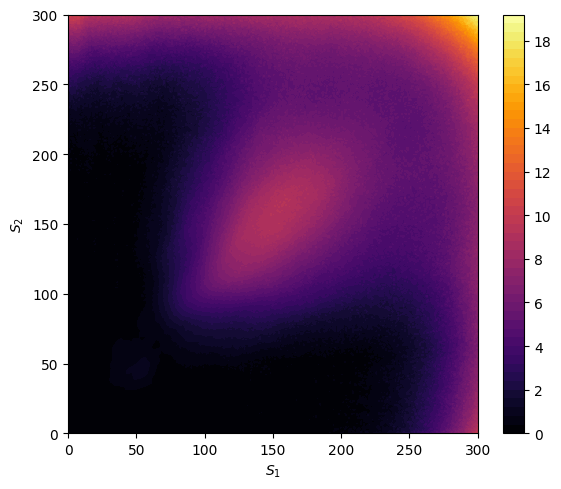

Saved plot for t=0.00 → mean_error_Call_BO_t00.png


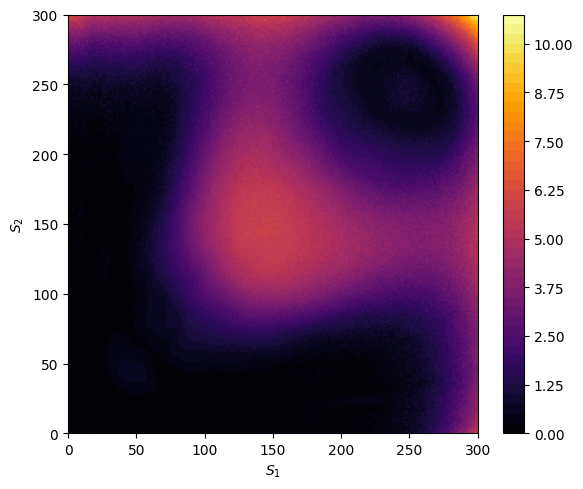

Saved plot for t=0.33 → mean_error_Call_BO_t33.png


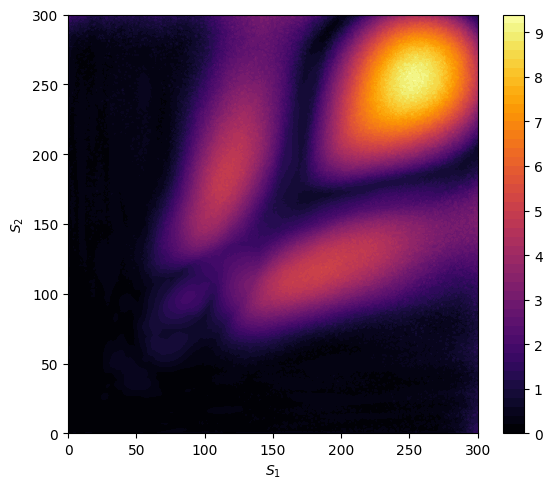

Saved plot for t=0.67 → mean_error_Call_BO_t66.png


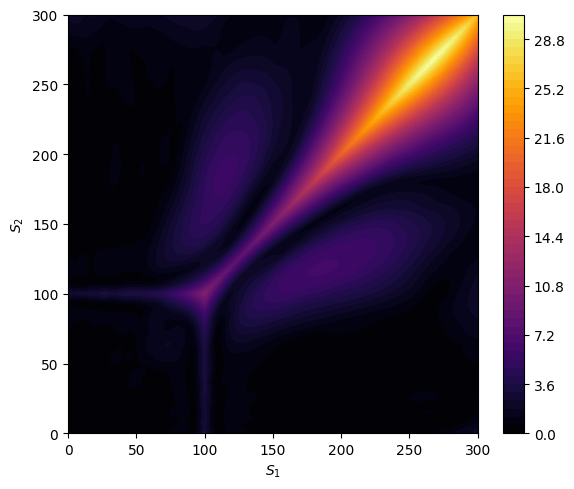

Saved plot for t=1.00 → mean_error_Call_BO_t100.png


In [ ]:
for t_val in t_slices:
    mean_err = np.stack(abs_error_runs[t_val], axis=0).mean(axis=0)

    plt.figure(figsize=(6,5))
    cf = plt.contourf(G1, G2, mean_err, levels=50, cmap="inferno")
    plt.colorbar(cf)
    plt.xlabel("$S_1$")
    plt.ylabel("$S_2$")
    filename = f"mean_error_Call_BO_t{int(100*t_val):02d}.png"
    fullpath = f"{drive_path}/{filename}"
    plt.tight_layout()
    plt.savefig(fullpath, dpi=300)
    plt.show()
    print(f"Saved plot for t={t_val:.2f} → {filename}")

## 10. Greeks

In [ ]:
eps = 2
mask = (G1 >= eps) & (G2 >= eps)  # mask out noisy corners

In [ ]:
def build_batches(t_val):
    t_flat = np.full((g*g,1), t_val, dtype=np.float32)
    return (
        tf.constant(t_flat),
        tf.constant(G1.reshape(-1,1)),
        tf.constant(G2.reshape(-1,1))
    )

### 10.1 Delta Surface Analysis

In [ ]:
@tf.function
def compute_deltas(t_b, S1_b, S2_b, model):
    with tf.GradientTape() as tape:
        tape.watch([S1_b, S2_b])
        Vflat = model(t_b, S1_b, S2_b)
    return tape.gradient(Vflat, [S1_b, S2_b])

for asset_idx, name in enumerate(['S1','S2']):
    for t_val in t_slices:
        t_b, S1_b, S2_b = build_batches(t_val)
        runs = []
        for m in models:
            with tf.device("/GPU:0"):
                d1, d2 = compute_deltas(t_b, S1_b, S2_b, m)
            surf = (d1 if asset_idx==0 else d2).numpy().reshape(g,g)
            runs.append(np.where(mask, surf, np.nan))

        # overlay of all runs
        fig = plt.figure(figsize=(6,5))
        ax  = fig.add_subplot(111, projection='3d')
        cmap = plt.get_cmap('tab10')
        for i, surf in enumerate(runs):
            ax.plot_surface(G1, G2, surf, color=cmap(i), alpha=0.5, edgecolor='none')
        ax.set_xlabel('S1'); ax.set_ylabel('S2')
        ax.set_zlabel(f'Δ₍{name}₎(t={t_val:.2f})', labelpad=1)
        filename = f"overlay_delta_{name}_Call_BO_t{int(t_val*100):02d}.png"
        fullpath = f"{drive_path}/{filename}"
        plt.savefig(fullpath, dpi=300)
        plt.show()
        print(f"Saved {filename}")

        # mean ±1σ
        arr       = np.stack(runs, axis=0)
        mean_surf = np.nanmean(arr, axis=0)
        std_surf  = np.nanstd(arr, axis=0)

        fig = plt.figure(figsize=(6,5))
        ax  = fig.add_subplot(111, projection='3d')
        ax.plot_surface(G1, G2, mean_surf, cmap='coolwarm', edgecolor='none')
        ax.plot_surface(G1, G2, mean_surf+std_surf, color='gray', alpha=0.2, edgecolor='none')
        ax.plot_surface(G1, G2, mean_surf-std_surf, color='gray', alpha=0.2, edgecolor='none')
        ax.set_xlabel('S1'); ax.set_ylabel('S2')
        ax.set_zlabel(f'Δ̄₍{name}₎±1σ (t={t_val:.2f})', labelpad=1)
        filename = f"mean_delta_{name}_Call_BO_t{int(t_val*100):02d}.png"
        fullpath = f"{drive_path}/{filename}"
        plt.savefig(fullpath, dpi=300)
        plt.show()
        print(f"Saved {filename}")

Output hidden; open in https://colab.research.google.com to view.

### 10.2 Gamma Surface Analysis

In [ ]:
@tf.function
def compute_gammas(t_b, S1_b, S2_b, model):
    with tf.GradientTape(persistent=True) as g2:
        g2.watch([S1_b, S2_b])
        with tf.GradientTape() as g1:
            g1.watch([S1_b, S2_b])
            Vflat = model(t_b, S1_b, S2_b)
        dV_dS1, dV_dS2 = g1.gradient(Vflat, [S1_b, S2_b])
    gamma_S1 = g2.gradient(dV_dS1, S1_b)
    gamma_S2 = g2.gradient(dV_dS2, S2_b)
    return tf.squeeze(gamma_S1,1), tf.squeeze(gamma_S2,1)

for asset_idx, name in enumerate(['S1','S2']):
    for t_val in t_slices:
        t_b, S1_b, S2_b = build_batches(t_val)
        runs = []
        for m in models:
            with tf.device("/GPU:0"):
                g1, g2 = compute_gammas(t_b, S1_b, S2_b, m)
            surf = (g1 if asset_idx==0 else g2).numpy().reshape(g,g)
            runs.append(np.where(mask, surf, np.nan))

        # overlay of all runs
        fig = plt.figure(figsize=(6,5))
        ax  = fig.add_subplot(111, projection='3d')
        cmap = plt.get_cmap('tab10')
        for i, surf in enumerate(runs):
            ax.plot_surface(G1, G2, surf, color=cmap(i), alpha=0.5, edgecolor='none')
        ax.set_xlabel('S1'); ax.set_ylabel('S2')
        ax.set_zlabel(f'Γ₍{name}₎(t={t_val:.2f})', labelpad=1)
        filename = f"overlay_gamma_{name}_Call_BO_t{int(t_val*100):02d}.png"
        fullpath = f"{drive_path}/{filename}"
        plt.savefig(fullpath, dpi=300)
        plt.show()
        print(f"Saved {filename}")

        # mean ±1σ
        arr  = np.stack(runs, axis=0)
        mean = np.nanmean(arr, axis=0)
        std  = np.nanstd(arr, axis=0)
        fig = plt.figure(figsize=(6,5))
        ax  = fig.add_subplot(111, projection='3d')
        ax.plot_surface(G1, G2, mean, cmap='coolwarm', edgecolor='none')
        ax.plot_surface(G1, G2, mean+std, color='gray', alpha=0.2, edgecolor='none')
        ax.plot_surface(G1, G2, mean-std, color='gray', alpha=0.2, edgecolor='none')
        ax.set_xlabel('S1'); ax.set_ylabel('S2')
        ax.set_zlabel(f'Γ̄₍{name}₎±1σ (t={t_val:.2f})', labelpad=1)
        filename = f"mean_gamma_{name}_Call_BO_t{int(t_val*100):02d}.png"
        fullpath = f"{drive_path}/{filename}"
        plt.savefig(fullpath, dpi=300)
        plt.show()
        print(f"Saved {filename}")

Output hidden; open in https://colab.research.google.com to view.

### 10.3 Theta Surface Analysis

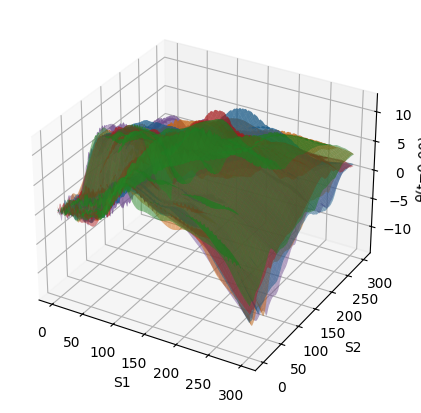

Saved mean_gamma_S2_Call_BO_t100.png


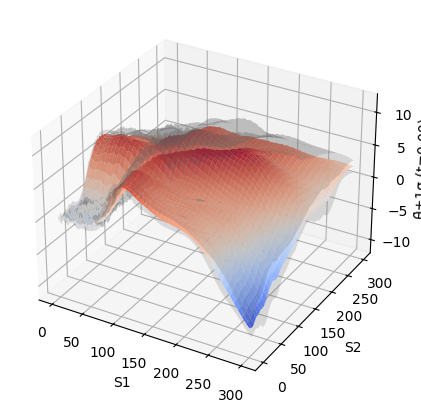

Saved mean_theta_Call_BO_t00.png


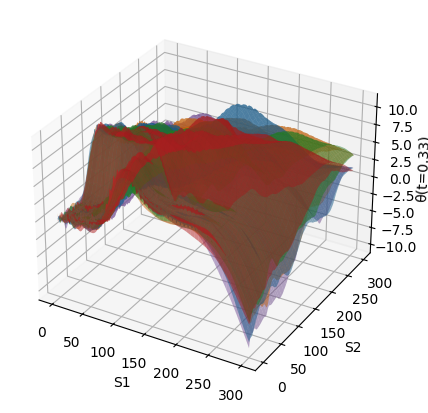

Saved mean_theta_Call_BO_t00.png


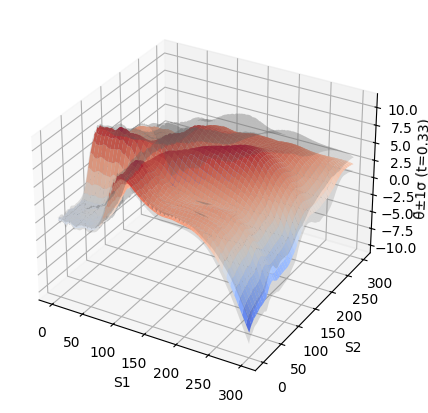

Saved mean_theta_Call_BO_t33.png


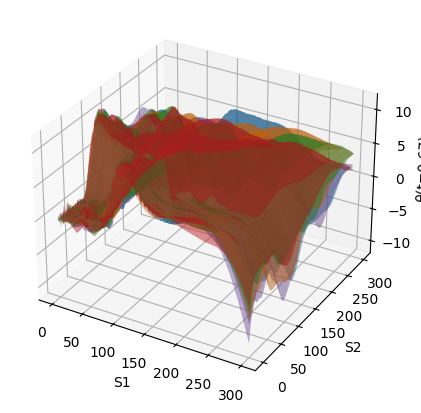

Saved mean_theta_Call_BO_t33.png


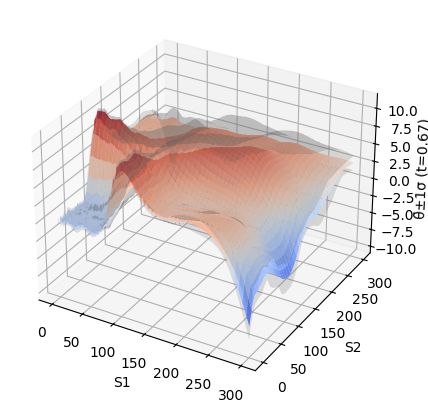

Saved mean_theta_Call_BO_t66.png


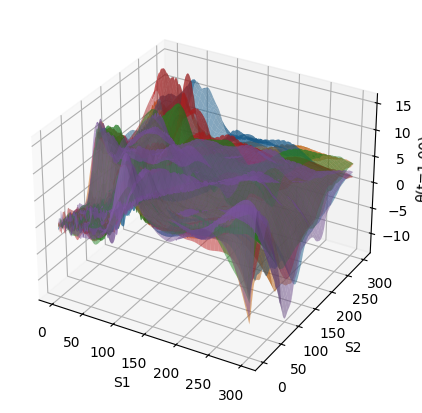

Saved mean_theta_Call_BO_t66.png


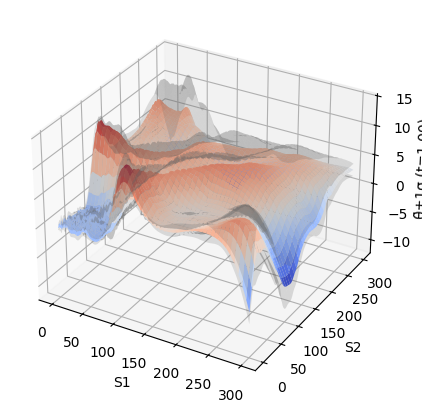

Saved mean_theta_Call_BO_t100.png


In [ ]:
@tf.function
def compute_theta(t_b, S1_b, S2_b, model):
    with tf.GradientTape() as g:
        g.watch(t_b)
        Vflat = model(t_b, S1_b, S2_b)
    dV_dt = g.gradient(Vflat, t_b)
    return tf.squeeze(-dV_dt, axis=1)

for t_val in t_slices:
    t_b, S1_b, S2_b = build_batches(t_val)
    theta_runs = []
    for m in models:
        with tf.device("/GPU:0"):
            th = compute_theta(t_b, S1_b, S2_b, m)
        theta_runs.append(th.numpy().reshape(g, g))

    # overlay of all runs
    fig = plt.figure(figsize=(6,5))
    ax  = fig.add_subplot(111, projection='3d')
    cmap = plt.get_cmap('tab10')
    for i, surf in enumerate(theta_runs):
        ax.plot_surface(G1, G2, surf,
                        color=cmap(i), alpha=0.5, edgecolor='none')
    ax.set_xlabel('S1'); ax.set_ylabel('S2')
    ax.set_zlabel(f'θ(t={t_val:.2f})', labelpad=1)
    file_name = f"overlay_theta_Call_BO_t{int(t_val*100):02d}.png"
    fullpath = f"{drive_path}/{filename}"
    plt.savefig(fullpath, dpi=300)
    plt.show()
    print(f"Saved {filename}")

    # mean ±1σ
    arr  = np.stack(theta_runs, axis=0)
    mean = arr.mean(axis=0)
    std  = arr.std(axis=0)

    fig = plt.figure(figsize=(6,5))
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot_surface(G1, G2, mean, cmap='coolwarm', edgecolor='none')
    ax.plot_surface(G1, G2, mean + std,
                    color='gray', alpha=0.2, edgecolor='none')
    ax.plot_surface(G1, G2, mean - std,
                    color='gray', alpha=0.2, edgecolor='none')
    ax.set_xlabel('S1'); ax.set_ylabel('S2')
    ax.set_zlabel(f'θ̄±1σ (t={t_val:.2f})', labelpad=1)
    filename = f"mean_theta_Call_BO_t{int(t_val*100):02d}.png"
    fullpath = f"{drive_path}/{filename}"
    plt.savefig(fullpath, dpi=300)
    plt.show()
    print(f"Saved {filename}")